In [110]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [111]:
deep = sns.color_palette('deep')
deep

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [112]:
palette = [deep[1], deep[0], deep[2], deep[4], deep[3]]

In [113]:
con = duckdb.connect()

con.execute("""
CREATE MACRO pretty_system(s) AS
CASE s
WHEN 'duckdb' THEN 'DuckDB'
WHEN 'hyper' THEN 'HyPer'
WHEN 'postgresql' THEN 'PostgreSQL'
WHEN 'umbra' THEN 'Umbra'
ELSE s END
""")
con.execute("""
CREATE MACRO pretty_parameter(s) AS
CASE s
WHEN 'build_alpha' THEN 'Inner Skew'
WHEN 'build_payload_columns' THEN 'Inner Width'
WHEN 'build_row_count' THEN 'Inner Cardinality'
WHEN 'key_count' THEN 'Unique Key Count'
WHEN 'probe_alpha' THEN 'Outer Skew'
WHEN 'probe_payload_columns' THEN 'Outer Width'
WHEN 'probe_row_count' THEN 'Outer Cardinality'
ELSE s END
""")

systems = ["duckdb", "hyper"]

for system in sorted(systems):
    con.execute(f"""ATTACH IF NOT EXISTS '../results/{system}.duckdb' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE VIEW IF NOT EXISTS all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_df = con.execute("""
SELECT * REPLACE (median(t) AS t)
FROM all_results
GROUP BY ALL
ORDER BY ALL""").fetchdf()
results_df.head()

,system,experiment,parameter,value,t
0,duckdb,join,build_alpha,0.0,50.314033
1,duckdb,join,build_alpha,0.25,51.783374
2,duckdb,join,build_alpha,0.5,51.882609
3,duckdb,join,build_alpha,0.75,52.255812
4,duckdb,join,build_alpha,1.0,136.993331


In [114]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.75',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [115]:
def millions(x, pos):
    """The two arguments are the value and tick position."""
    return f'{x*1e-6:1.0f}M'

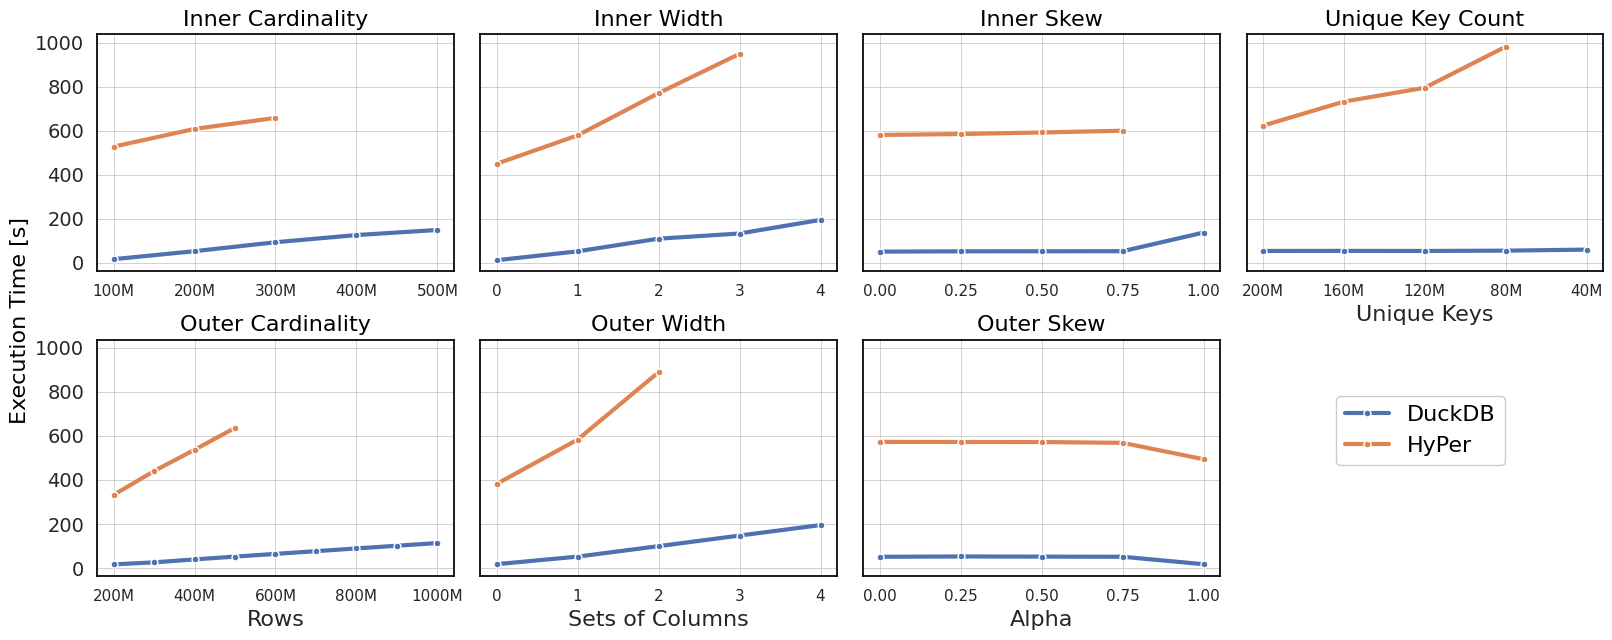

In [116]:
f = plt.figure(figsize=(16, 6.5), dpi=100)

fontsize = 16
tickfontsize = 14

modified_style = copy.copy(my_style)
modified_style['xtick.major.bottom'] = True
modified_style['axes.labelsize'] = fontsize
modified_style['ytick.labelsize'] = tickfontsize
modified_style['grid.linewidth'] = 0.5
modified_style['ytick.major.left'] = False
modified_style['axes.titlesize'] = fontsize

systems_ordered = ["DuckDB"]

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) AS "System",
                   pretty_parameter(parameter) AS "Parameter",
                   value::DOUBLE AS "Value",
                   t AS "Execution Time [s]",
            FROM results_df
            WHERE experiment = 'join'
            AND t > 0
            ORDER BY ALL
        """).fetchdf(),
        x='Value', y='Execution Time [s]', color='System'
    )
    .facet(col='Parameter', order=['Inner Cardinality', 'Inner Width', 'Inner Skew', 'Unique Key Count', 'Outer Cardinality', 'Outer Width', 'Outer Skew'], wrap=4)
    .add(so.Line(linewidth=3, marker='o', pointsize=5, edgecolor='w'))
    .share(x=False, y=True)
    .theme(modified_style)
    .on(f)
    .plot()
)

for ax in f.axes:
    ax.set_ylabel('')
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[0], 1000-ylim[0]))

ax = f.axes[0]
ax.xaxis.set_major_formatter(millions)
ax.set_xlabel('Rows')

ax = f.axes[1]
ax.set_xlabel('Sets of Columns')

ax = f.axes[2]
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Alpha')

ax = f.axes[3]
ax.set_xticks([40e6, 80e6, 120e6, 160e6, 200e6])
ax.xaxis.set_major_formatter(millions)
ax.invert_xaxis()
ax.set_xlabel('Unique Keys')

ax = f.axes[4]
ax.xaxis.set_major_formatter(millions)
ax.set_xlabel('Rows')

ax = f.axes[5]
ax.set_xlabel('Sets of Columns')

ax = f.axes[6]
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Alpha')

f.text(0, 0.5, 'Execution Time [s]', rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=fontsize)

legend = f.legends.pop(0)
f.legend(legend.legend_handles, [t.get_text() for t in legend.texts],  bbox_to_anchor=(0.935, 0.4), framealpha=1, fontsize=fontsize)

f.subplots_adjust(hspace=0, wspace=0)
f.tight_layout()
f.savefig(f"../figures/join.eps", bbox_inches='tight')
# plt.close(f)